In [3]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torchvision.datasets

In [4]:
CIFAR_TRAIN = torchvision.datasets.CIFAR10(root='./', train=True, download=True)
CIFAR_TEST = torchvision.datasets.CIFAR10(root='./', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
X_train, y_train = torch.tensor(CIFAR_TRAIN.data, dtype= torch.float16), torch.tensor(CIFAR_TRAIN.targets, dtype=torch.int8)
X_test, y_test = torch.tensor(CIFAR_TEST.data, dtype= torch.float16), torch.tensor(CIFAR_TEST.targets, dtype=torch.int8)

In [31]:
X_train = X_train.permute((0, 3, 1, 2))
X_test = X_test.permute((0, 3, 1, 2))

In [32]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [53]:
idx_to_class = {k : v for k, v in zip(np.arange(0, 11), CIFAR_TRAIN.classes)}

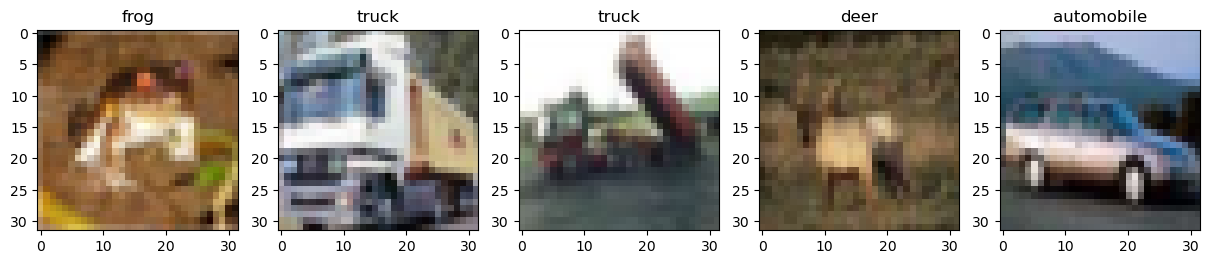

In [55]:
fig, ax = plt.subplots(1, 5, figsize=(15,4))
for i in range(5):
    ax[i].imshow(X_train[i].permute((1, 2, 0)).to(torch.int16))
    ax[i].title.set_text(idx_to_class[y_train[i].item()])
plt.show();

In [61]:
from torch.utils.data import DataLoader, TensorDataset

In [63]:
train_loader = DataLoader(
    TensorDataset(X_train, y_train), batch_size=64, pin_memory=True, shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test), batch_size=64, pin_memory=True, shuffle=True
)

In [64]:
def acc_fn(y_true, y_preds):
    if y_true.shape != y_preds.shape:
        return ValueError("Wrong shapes y_true and y_preds")
    return torch.sum(y_true == y_preds) / len(y_true)

In [76]:
def plot_train_func(train_loss_hist, test_loss_hist, test_acc_hist):
    d = {
        0 : train_loss_hist,
        1 : test_loss_hist,
        2 : test_acc_hist
	}
    names = {
        0 : "Train loss",
        1 : "Test loss",
        2 : "Test accuracy"
    }
    fig, ax = plt.subplots(1, 3, figsize=(15,4))
    for i in range(3):
        ax[i].plot(d[i])
        ax[i].grid()
        ax[i].set_title(names[i])
    plt.show();

#### Define optimal model for CIFAR

In [70]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels = 1, out_channesl = 6, depth = 2):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == 0:
                self.layers.append(nn.Conv2d(in_channels, out_channesl, 3, padding=1))
            else:
                self.layers.append(nn.Conv2d(out_channesl, out_channesl, 3, padding=1))
            self.layers.append(nn.ReLU(inplace=True))
            self.layers.append(nn.BatchNorm2d(out_channesl))
        self.layers.append(nn.MaxPool2d(2, 2))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [71]:
class CifarModel(nn.Module):
    def __init__(self, in_channels = 3, out_classes = 10, hidden = 384):
        super().__init__()
        self.block1 = ConvBlock(in_channels, 12)  # 32 -> 16
        self.block2 = ConvBlock(12, 24)  # 16 -> 8
        self.block3 = ConvBlock(24, 48)  # 8 -> 4
        self.fc1 = nn.Linear(4 * 4 * 48, hidden)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm1d(hidden)
        self.fc2 = nn.Linear(hidden, out_classes)
    
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        return self.fc2(x)

In [215]:
def train_func(tr_l, ts_l, loss_fn, acc_fn, device, epochs=100, lr = 1e-4, model_class = None, model = None):
    if model_class == None and model == None:
        raise ValueError("Model empty")
    train_loss_hist = []
    test_loss_hist = []
    test_acc_hist = []
    
    if model == None:
        model = model_class().half().to(device)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.7)
    
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        for X, y in tr_l:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(tr_l)
        train_loss_hist.append(train_loss)

        
        if epoch % (epochs // 10) == 0:
            
            model.eval()
            test_loss = 0
            test_acc = 0
            
            with torch.no_grad():
                for X, y in ts_l:
                    X, y = X.to(device), y.to(device)
                    preds = model(X)
                    test_loss += loss_fn(preds, y).item()
                    test_acc += acc_fn(y, torch.argmax(preds, dim=1)).item()
            
            test_loss /= len(ts_l)
            test_acc /= len(ts_l)
            test_loss_hist.append(test_loss)
            test_acc_hist.append(test_acc)
            
            print(
                f"Epoch: {epoch}\ttrain loss: {loss}\ttest loss:{test_loss}\ttest acc:{test_acc}"
            )
    return (model, train_loss_hist, test_loss_hist, test_acc_hist)

In [205]:
loss_fn = torch.nn.CrossEntropyLoss()

In [156]:
trained_model, tr_loss_hist, ts_loss_hist, ts_acc_hist = train_func(train_loader, 
                                                            test_loader, loss_fn, 
                                                            acc_fn, device, 10, 3e-3, CifarModel)

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

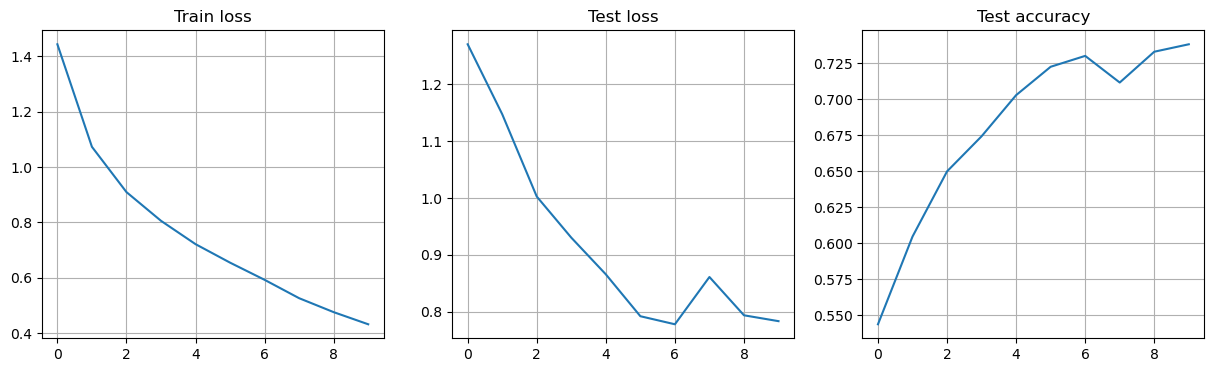

In [134]:
plot_train_func(tr_loss_hist, ts_loss_hist, ts_acc_hist)

In [135]:
test_acc = 0

with torch.no_grad():
                for X, y in test_loader:
                    X, y = X.to(device), y.to(device)
                    preds = trained_model(X)
                    test_acc += acc_fn(y, torch.argmax(preds, dim=1)).item()
                    
test_acc /= len(test_loader)
f"Accuracy: {test_acc}"

'Accuracy: 0.7383558917197452'

#### Let's define ResNet model to improve accuracy

In [206]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.relu,
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
    
    def forward(self, x):
        identity = x.clone()
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

In [211]:
class ResNet(nn.Module):
    def __init__(self, resblock, layers, out_classes):
        super().__init__()
        self.channesl = 64
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU()
        )
        self.mp = nn.MaxPool2d(2, 2)  # 32 -> 16

        self.layer1 = self.make_layer(resblock, 64, layers[0], 1)  # 16
        self.layer2 = self.make_layer(resblock, 128, layers[1], 2)  # 8
        self.layer3 = self.make_layer(resblock, 256, layers[2], 2)  # 4
        self.layer4 = self.make_layer(resblock, 512, layers[3], 2)  # 2
        self.pool = nn.AvgPool2d(2, 2)  # 1
        self.fc = nn.Linear(512, out_classes)

    def make_layer(self, block, channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.channesl != channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.channesl, channels, 1, stride), nn.BatchNorm2d(channels)
            )

        layers = []
        for i in range(num_blocks):
            if i == 0:
                layers.append(block(self.channesl, channels, stride, downsample))
                self.channesl = channels
            else:
                layers.append(block(self.channesl, channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mp(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        return x

In [212]:
import gc

gc.collect()

torch.mps.empty_cache()

In [219]:
model = ResNet(ResBlock, [2, 3, 4, 2], 10).half().to(device)

In [220]:
trained_model, tr_loss_hist, ts_loss_hist, ts_acc_hist = train_func(train_loader, 
                                                            test_loader, loss_fn, 
                                                            acc_fn, device, 10, 3e-2, model = model)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0	train loss: 0.9921875	test loss:1.5314490445859872	test acc:0.4837778662420382
Epoch: 1	train loss: 0.407958984375	test loss:1.1500640674761147	test acc:0.6189291401273885
Epoch: 2	train loss: 1.4033203125	test loss:1.3183251642117835	test acc:0.5726512738853503


KeyboardInterrupt: 